In [13]:
import numpy as np
import matplotlib.pyplot as plt

M_sun=1.989e+30  # M_sun in kg
Mega_parsec=3.086e+22  # parsec in metres
z=0         # Redshift specification

Delta=200.0   # Overdensity definition = Delta X background

# WMAP1 Cosmology
omega_m=0.270062   # Density parameter for matter in the Universe WMAP1 Cosmology (Niladri's=0.276)
h=0.72  # 100h km /s MPc is Hubble constant today WMAP1 Cosmology (Niladri's=0.7)

rho_cr=((3*np.power((100*h),2))/(8*np.pi*6.673e-11))*((Mega_parsec/h**3)*1e+6/(M_sun/h))
# critical density of the Universe today 3H^2/8Pi*G in units M_sun.h^-1/(MPc.h^-1)^3
rho_m=omega_m*rho_cr*((1+z)**3)  # where a=1/(1+z)   Units same as rho_cr

M_min=2.6765e+11  # Units of Msun/h
M_max=6.0536e+11  # Units of Msun/h

eps=1e-10

In [14]:
# Input data : Normalised Power spectrum
#PS=np.loadtxt("./../Data/power_spectrum_camb_su1024_cosmology.txt")
PS=np.loadtxt("./../Normalize PS/NormalizedDimensionlessPS.txt")

In [15]:
# Smoothing window functions Fourier Transformed in k-space
def TopHat(k,R):
    return (3/np.power(k*R,3))*(np.sin(k*R)-(k*R)*np.cos(k*R))

def Gaussian(k,R):
    return np.exp(np.power((k*R),2)/-2.0)

In [16]:
# The smoothing scale R as a function of M. M to be passed in units M_sun/h. R returned will be in MPc/h 
# k is in units h/MPc, therefore kR will be unitless in the smoothening window
const1=np.cbrt(3.0/(4*np.pi*rho_m))
def R(M):
    return const1*np.cbrt(M)

In [17]:
# The rms variance of the linear density field smoothed on scale R(M)
# Requires inputs on mass of halo in M_sun (to define R(M)) and the smoothing window type
# Fourier modes 'k' are interpreted from the Power Spectrum by default.

def sigma(M,W="TopHat",kmin=-1.0,kmax=-1.0):
    kbins=[]
    if (kmin==-1 and kmax>=0) or (kmin>=0 and kmax==-1):
        print("Limits to the modes 'k' not set properly")
        exit()
    if kmin==-1 and kmax==-1:
        kbins=PS[:,0]

    r=R(M)
    window=[]
    
    if(W=="TopHat"):
        for i in range(0,len(kbins)):
            window.append(TopHat(kbins[i],r))
    if(W=="Gaussian"):
        for i in range(0,len(kbins)):
            window.append(Gaussian(kbins[i],r))
    
    kbins=np.log(kbins)
    ps=np.array(PS[:,1])*2*(np.pi**2)
    ps=ps/np.power(kbins,3)
    
    function=np.array(ps)*np.power(np.array(window),2)*np.power(kbins,3)
#    result=np.sum((np.log(kbins[1:])-np.log(kbins[:-1]))*(function[1:]+function[:-1])/2.0)
    result=np.trapz(function,kbins)
    return result

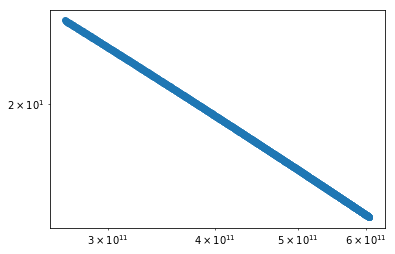

In [18]:
Mb=np.linspace(M_min,M_max,1000)
s=[]
for i in range(0,len(Mb)):
    s.append(sigma(Mb[i],W="Gaussian"))

plt.scatter(Mb,s)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [19]:
# Parameters according to those given in the Tinker2008 paper [https://arxiv.org/pdf/0803.2706.pdf]
params=np.loadtxt("./param.txt")
d=np.where(params[:,0]==Delta)
A=float(params[d,1])*np.power((1+z),-0.14)
a=float(params[d,2])*np.power((1+z),-0.06)
alpha=np.exp(-1.0*np.power((0.75/np.log(Delta/75)),1.2))    # required for Redshift evolution of parameter 'b'
b=float(params[d,3])*np.power((1+z),-1.0*alpha)
c=float(params[d,4])


In [20]:
# This function finds the Tinker Universal fit for the Halo Mass function f(sigma)
# It uses the Tinker parameters and argument is M in units M_sun

def f(M):
    s=sigma(M,W="Gaussian")
    term0=s/b
    term1=1.0+np.power(term0,-1.0*a)
    term2=A*term1*np.exp(-1.0*c/(s**2))
    return term2

In [21]:
# This function returns the Tinker mass function dn/dm.
# 30 bins are created by defualt between M_min and M_max as defined in the preamble above unless specified otherwise
# Returns an array of number of Halos populating each mass bin
#
def TMF(numOfBins=30,M_lower=-1,M_upper=-1):
    massBins=[]
    if(M_lower==-1 and M_upper>=0) or (M_lower>=0 and M_upper==-1):
        print("Invalid upper or lower limit on the mass of halos")
        exit()
    if(M_lower==-1 and M_upper==-1):
        last=np.log(M_max/M_min)
        massBins=M_min*np.exp(np.linspace(0.0,last,numOfBins))
        massBins_lin=np.linspace(M_min,M_max,numOfBins)
    else:
        last=np.log(M_upper/M_lower)
        massBins=M_lower*np.exp(np.linspace(0.0,last,numOfBins))
        massBins_lin=np.linspace(M_lower,M_upper,numOfBins)
        
    dM=massBins[1:]-massBins[:-1]   # dM
    dlnM=np.log(massBins[1:])-np.log(massBins[:-1])
    M_mid=(massBins[1:]+massBins[:-1])/2.0
    
    sig,f_sig=[],[]
    sig_lin=[]
    for i in range(0,len(massBins)):
        sig.append(sigma(massBins[i],W="Gaussian"))
        sig_lin.append(sigma(massBins_lin[i],W="Gaussian"))
        
    sig=np.array(sig)
    sig_lin=np.array(sig_lin)
    
    sig=-1.0*np.log(sig)
    dln_siginv=sig[1:]-sig[:-1]   # dln(sigma^-1)
    
    for i in range(0,len(M_mid)):
        f_sig.append(f(M_mid[i]))   # f(sigma)
    f_sig=np.array(f_sig)    # f reduces to negligible values too soon
    
    term1=f_sig
    term2=rho_m/(M_mid**2)
    term3=dln_siginv/dlnM
    result=(term1*term2*term3)
    return result,M_mid

In [22]:
# Plotting and comparing with Tinker MF Graph in the paper
M_lower=1e+10
M_upper=1e+16
nOB=100
res,m_mid=TMF(nOB,M_lower,M_upper)

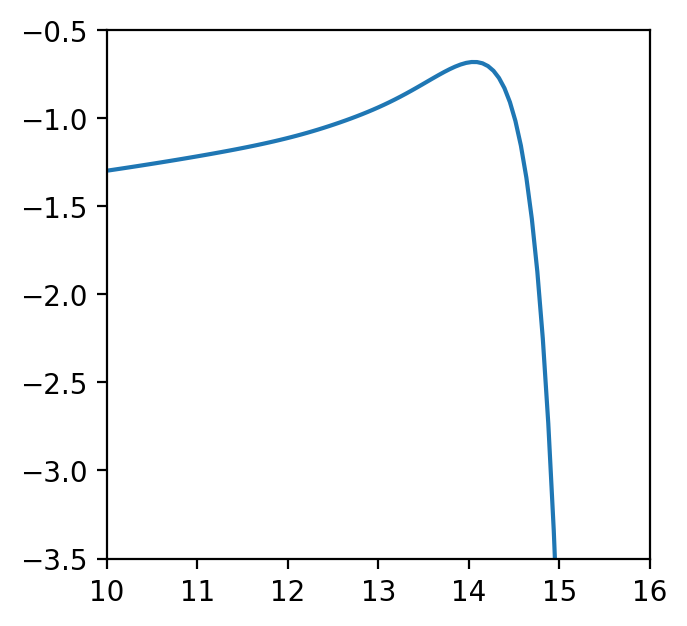

In [23]:
y=np.log10((m_mid**2/rho_m)*res)
x=np.log10(m_mid)
plt.figure(figsize=(3.5,3.5), dpi=200, facecolor='w', edgecolor='k')
plt.plot(x,y,markersize=1)
plt.ylim([-3.5,-0.5])
plt.xlim([10,16])
plt.show()